<a href="https://colab.research.google.com/github/Mrezakhodashenas/PhD-NN/blob/main/snn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.4 MB/s 


In [8]:
import snntorch as snn
import torch
import itertools
from torchvision import datasets, transforms
from snntorch import spikeplot as splt
from snntorch import spikegen
import torch.nn as nn
import matplotlib.pyplot as plt
import torch 
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
from torchvision import datasets, transforms
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import ELU, PReLU, LeakyReLU
import matplotlib.pyplot as plt
from collections import namedtuple
import datetime
%matplotlib inline

In [9]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                         gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)    # alpha=0.25 determines the brightness
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")      #  s=400 determines the length of the | 
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [10]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold    #  based on Equation (10): U[t+1]=beta.U[t] + W.X[t+1] - S[t].Uthre = decay + input - reset
  return spk, mem

# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)         # beta: Decay Rate , U(t+dt)=beta.U(t), beta= 1-(dt/RC)

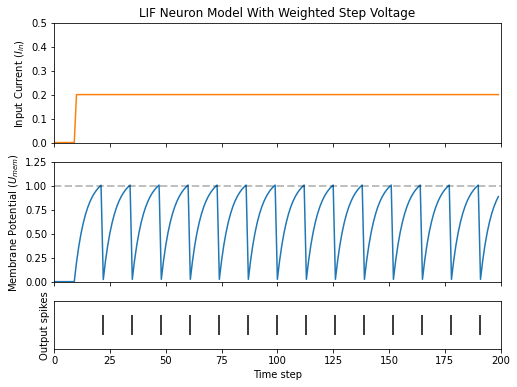

In [11]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

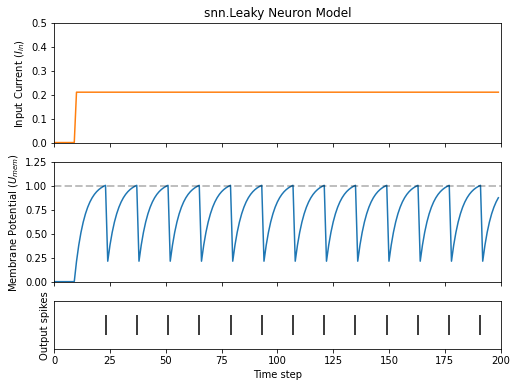

In [12]:
lif1 = snn.Leaky(beta=0.8)
# The neuron model is now stored in lif1

# cur_in : W*X[t]  input
# mem : U[t-1]    input
# spk_out:  S[t]   output spike    ,   (‘1’ if there is a spike; ‘0’ if there is no spike)
# mem : U[t]

# Small step current input
w=0.21
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max1=0.5,
                 title="snn.Leaky Neuron Model")

Dimensions of spk_in: torch.Size([200, 1, 784])


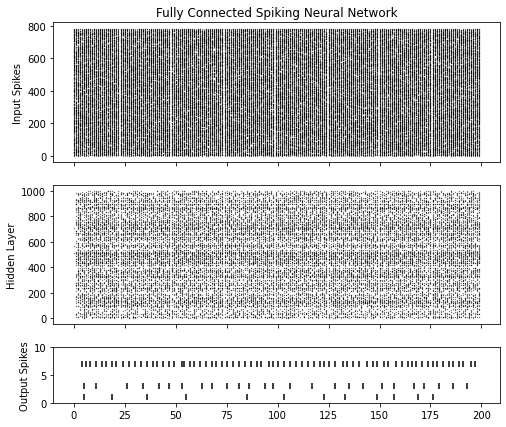

In [13]:
# ---------------------------------------   A Feedforward Spiking Neural Network

# PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models
# PyTorch is used to form the connections between neurons, and snnTorch to create the neurons. 


# First, initialize all layers:

# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)       # scaling the input current with a weight generated by nn.Linear, rather than manually setting W ourselves.
lif1 = snn.Leaky(beta=beta)
fc2 = nn.Linear(num_hidden, num_outputs)
lif2 = snn.Leaky(beta=beta)


# initialize the hidden variables and outputs of each spiking neuron
# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []


# Create an input spike train to pass to the network. 
# There are 200 time steps to simulate across 784 input neurons, i.e., the input originally has dimensions of 200×784. [time* batch_size* feature_dimensions]

# So 'unsqueeze' the input along dim=1 to indicate 'one batch' of data. The dimensions of this input tensor must be 200*1*784
spk_in = spikegen.rate_conv(torch.rand((200, 784))).unsqueeze(1)
print(f"Dimensions of spk_in: {spk_in.size()}")



# --------------------------- network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step]) # post-synaptic current <-- spk_in x weight
    spk1, mem1 = lif1(cur1, mem1) # mem[t+1] <--post-syn current + decayed membrane
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

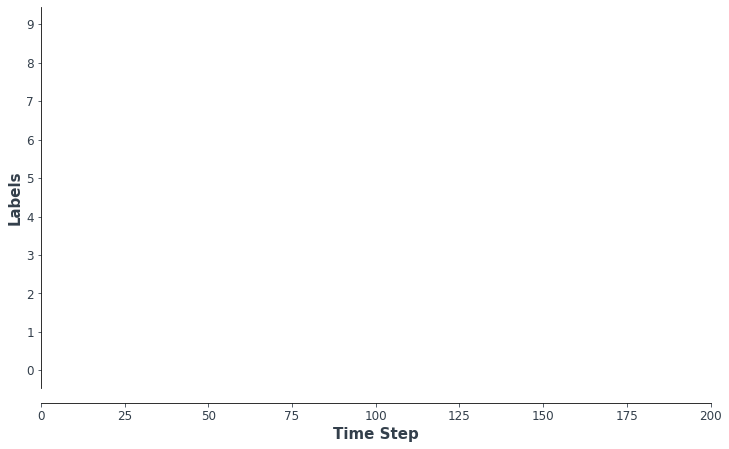

In [14]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
    # splt.spike_count can create a spike counter of the output layer
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")


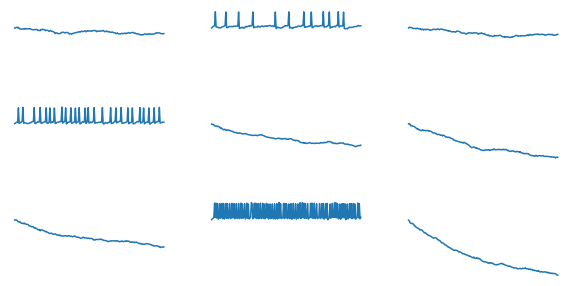

In [15]:
# splt.traces lets you visualize the membrane potential traces. 
# We will plot 9 out of 10 output neurons.
#  Compare it to the animation and raster plot above to see if you can match the traces to the neuron.


# plot membrane potential traces
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf() 
fig.set_size_inches(10, 5)

In [16]:
# Iin[t]= W*X[t]:  input synaptic current.  X[t]: arbitrary input of spikes, a step/time-varying voltage, or unweighted step/time-varying current.

# Leaky neuron model, overriding the backward pass with a custom function
class LeakySurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0):
      super(LeakySurrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.spike_op = self.SpikeOperator.apply
  
  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.spike_op((mem-self.threshold))  # call the Heaviside function
    reset = (spk * self.threshold).detach() # removes spike_op gradient from reset
    mem = self.beta * mem + input_ - reset # Eq (1).  U[t+1] = beta*U[t] + W*X[t+1] - R[t]
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with the Spike itself
  @staticmethod
  class SpikeOperator(torch.autograd.Function):
      @staticmethod
      def forward(ctx, mem):
          spk = (mem > 0).float() # Heaviside on the forward pass: Eq(2)
          ctx.save_for_backward(spk)  # store the spike for use in the backward pass
          return spk

      @staticmethod
      def backward(ctx, grad_output):
          (spk,) = ctx.saved_tensors  # retrieve the spike 
          grad = grad_output * spk # scale the gradient by the spike: 1/0
          return grad


In [17]:
lif1 = LeakySurrogate(beta=0.9)
# lif1 = snn.Leaky(beta=0.9) #  every time you call any neuron model from snnTorch, the Spike Operator surrogate gradient is applied to it by default


In [18]:
#  Backprop Through Time

# The backpropagation through time (BPTT) algorithm calculates the gradient from the loss to all descendants and sums them together.
# The weight W is applied at every time step, and so imagine a loss is also calculated at every time step. 
# The influence of the weight on present and historical losses must be summed together to define the global gradient



In [19]:
# Setting up the Loss / Output Decoding

# In a conventional, non-spiking neural network, a supervised, multi-class classification problem takes the neuron with the highest activation and treats that as the predicted class.
# In a spiking neural net, there are several options to interpreting the output spikes. The most common approaches are:
# Rate coding: Take the neuron with the highest firing rate (or spike count) as the predicted class
# Latency coding: Take the neuron that fires first as the predicted class

In [20]:
# ----------------------------------------  Training a fully-connected spiking neural net:
    # Setting up the Static MNIST Dataset

# dataloader arguments
batch_size = 128
data_path='/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)


# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [21]:
# ------------------------------- ------------- ----------------------  Define the Network
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

# fc1:  applies a linear transformation to all input pixels from the MNIST dataset;
# lif1:  integrates the weighted input over time, emitting a spike if the threshold condition is met;
     
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
        
# Load the network onto CUDA if available
net = Net().to(device)

In [22]:
# --------------  ----------------  ------------------  -----------  Training the SNN

# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")


#   ---------- Loss Definition
# The nn.CrossEntropyLoss function in PyTorch automatically handles taking the softmax of the output layer as well as generating a loss at the output.
loss = nn.CrossEntropyLoss()


#   ------------   Optimizer

# Adam is a robust optimizer that performs well on recurrent networks, so let's use that with a learning rate of 5×10^−4
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# -------------- One Iteration of Training

# Take the first batch of data and load it onto CUDA if available.
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)


# Flatten the input data to a vector of size 784 and pass it into the network.
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

# The recording of the membrane potential is taken across:
# 25 time steps
# 128 samples of data
# 10 output neurons

# Calculate the loss at every time step, and sum these up together, as per Equation (10)
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
# The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad (it should be roughly around 10%) as the network is untrained:
print_batch_accuracy(data, targets, train=True)


# A single weight update is applied to the network as follows:
# clear previously stored gradients
optimizer.zero_grad()
# calculate the gradients
loss_val.backward()
# weight update
optimizer.step()

# -------------------------- membrane potential is used to calculate the cross entropy loss, and spike count is used for the measure of accuracy:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)
# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)


torch.Size([25, 128, 10])
Training loss: 59.725
Train set accuracy for a single minibatch: 13.28%
Training loss: 49.579
Train set accuracy for a single minibatch: 41.41%


In [23]:
# Training Loop
# training for one epoch (though feel free to increase num_epochs), exposing the network to each sample of data once.

num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 52.56
Test Set Loss: 48.88
Train set accuracy for a single minibatch: 56.25%
Test set accuracy for a single minibatch: 50.78%


Epoch 0, Iteration 50
Train Set Loss: 16.18
Test Set Loss: 15.72
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 84.38%


Epoch 0, Iteration 100
Train Set Loss: 11.89
Test Set Loss: 7.52
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 86.72%


Epoch 0, Iteration 150
Train Set Loss: 11.47
Test Set Loss: 13.57
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 200
Train Set Loss: 9.88
Test Set Loss: 6.73
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 9.83
Test Set Loss: 11.24
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 89.06%


Epoch

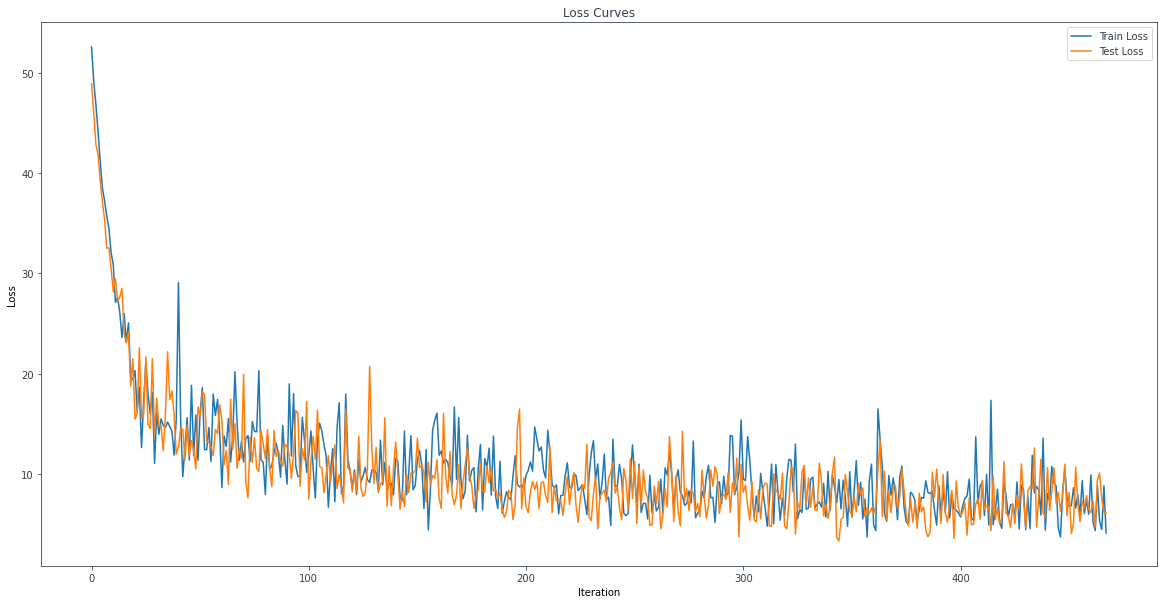

In [28]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 10))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations.



In [29]:

#------------ ----------------- -------------------------- Test Set Accuracy
# This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9372/10000
Test Set Accuracy: 93.72%
